In [1]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sympy import Matrix
import json
import argparse
from math import log

### Functions to be used

In [2]:
def encode_custom(tG, v, seed=None):
    n, k = tG.shape
    rng = check_random_state(seed)
    d = binaryproduct(tG, v)
    x = (-1) ** d
    y = x
    return y


def generate_random_symbols(n):
    # Generate n random bits as -1 or 1 using uniform sampling.
    return np.random.choice([-1, 1], size=n)


def transmit_data(data, channel, snr_db):
    # Apply channel gain to the transmitted data.
    signal = channel * data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise


def transmit_data_awgn(data, snr_db):
    # Apply channel gain to the transmitted data.
    signal = data
    # Calculate the signal power.
    signal_power = np.mean(np.abs(signal)**2)
    # Convert SNR from dB to linear scale and compute noise power.
    noise_power = signal_power / (10**(snr_db / 10))
    # Generate complex Gaussian noise.
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    # Add noise to the signal to create the received signal.
    return signal + noise


def estimate_channel(received, data):
    # Reshape the transmitted data for matrix operations.
    X = data.reshape(-1, 1)
    # Perform least squares estimation to solve for the channel.
    h = np.linalg.lstsq(X, received, rcond=None)[0][0]
    return h


def number_of_symbols(N, n, k):
    T = N // (k)
    #This is the number of symbols to be transmitted
    N1 = T*n
    return int(N1)


def decoder_custom_awgn(received):
    list1 = np.sign(np.real(received))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2


def decoder_custom_jakes(received, channel):
    list1 = np.sign(np.real(received / channel))
    list2 = []
    for i in list1:
        if i == -1:
            list2.append(1)
        if i == 1:
            list2.append(0)
    return list2


def generate_channels_for_doppler_frequencies(Fd, Fs, N):
    def jakes_sos(P, K, Fs, Fd, N, typ):
        # Create a time vector for sampling points
        t = np.linspace(0, P / Fs, P)
        # Calculate angular Doppler frequency
        omega_d = 2 * np.pi * Fd
        # Initialize an array to store Jakes random variables
        jakes_rvs = np.zeros((K, P), dtype=complex)
        # Loop through independent processes
        for k in range(K):
            # Generate random angles for sinusoids
            alpha = np.random.uniform(0, 2 * np.pi, N)
            # Adjust angles based on the number of sinusoids
            alpha_m = np.array([((2 * np.pi * n) - np.pi + al) / (4 * N) for n, al in enumerate(alpha)])
            # Generate random phase offsets for cosine terms
            a_m = np.random.uniform(0, 2 * np.pi, N)
            # Generate random phase offsets for sine terms
            b_m = np.random.uniform(0, 2 * np.pi, N)
            phi_m = np.random.uniform(-np.pi, np.pi, N)
            # Compute cosine terms for the real part
            cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + phi_m)
            # Sum the cosine contributions to form the real part
            real_part = np.sqrt(2 / N) * np.sum(cosine_terms, axis=1)
            # Check if generating complex signals
            if typ == 'comp':
                # Compute sine terms for the imaginary part
                sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + phi_m)
                # Sum the sine contributions to form the imaginary part
                imag_part = np.sqrt(2 / N) * np.sum(sine_terms, axis=1)
                # Combine real and imaginary parts
                jakes_rvs[k] = real_part + 1j * imag_part
            else:
                # Enforce complex format with zero imaginary part for real signals
                jakes_rvs[k] = real_part + 1j * 0
        # Return the generated Jakes random variables
        return jakes_rvs

    # Number of time points for the output
    P = N
    # Number of independent processes to simulate
    K = 1
    # Specify the type of random variables (complex)
    typ = 'comp'
    # Generate Jakes random variables using the SoS method
    jakes_rvs = jakes_sos(P, K, Fs, Fd, 100, typ)
    correlated_jakes_rvs = jakes_rvs
    # Open a file to write the generated channels
    with open("channels.txt", "w") as fo:
        # Iterate through each sample
        for i in range(P):
            # Extract the i-th sample
            new_sample = correlated_jakes_rvs[:, i]
            # Serialize complex numbers as (real, imag) pairs
            new_sample_serialized = [(z.real, z.imag) for z in new_sample]
            # Write serialized sample to the file
            json.dump(new_sample_serialized, fo)
            # Add a newline after each serialized sample
            fo.write('\n')
    # Return the generated Jakes random variables
    return correlated_jakes_rvs

### AWGN channel 

In [3]:
def awgn_simulate(N, SNR):
    # Initialize variables for simulation.
    current_index = 0  # Track the current position in channel values.
    total_packets = 0  # Total number of transmitted data bits.
    wrong_packets = 0  # Count of incorrectly received data bits.
    packet_message = np.random.randint(2, size = N)
    packet_symbol = [-1 if j == 1 else 1 for j in packet_message]
    received_symbols = transmit_data_awgn(packet_symbol, SNR)
    recovered_message = decoder_custom_awgn(received_symbols)
    for i in range(N):
        if recovered_message[i] != packet_message[i]:
            wrong_packets += 1
    total_packets += N
    
    if total_packets == 0:
        return None 
    else:
        return np.float16(wrong_packets / total_packets)     

In [4]:
# Define the range of SNR values to be simulated
snr_values = [round(x * 0.5, 1) for x in range(31)]
N = 10000

# Initialize lists to store BER for the approaches
ber_awgn_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_sum_awgn = 0  # For packetwise approach
    for i in range(3):
        ber_awgn = awgn_simulate(N, snr)
        ber_sum_awgn += ber_awgn
    ber_awgn_list.append(ber_sum_awgn / 3)

### Rayleigh channel + AWGN

In [5]:
def rayleigh_simulate(N, SNR):
    wrong_packets = 0  # Count of incorrectly received data bits.
    channel_vals = (1 / np.sqrt(2)) * (np.random.randn(N) + 1j * np.random.randn(N)) 
    packet_message = np.random.randint(2, size = N)
    encoded_packet_symbols = [-1 if j == 1 else 1 for j in packet_message]
    received_symbols = transmit_data(encoded_packet_symbols, channel_vals, SNR)
    recovered_message = decoder_custom_jakes(received_symbols, channel_vals)
    for i in range(len(recovered_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
    return np.float16(wrong_packets/N)     

In [6]:
# Define the range of SNR values to be simulated

# Initialize lists to store BER for the approaches
ber_ray_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_sum_ray = 0  # For packetwise approach
    for i in range(3):
        ber_ray = rayleigh_simulate(N, snr)
        ber_sum_ray += ber_ray
    ber_ray_list.append(ber_sum_ray / 3)

### Jakes channel + AWGN

In [10]:
def corr_simulate(Fd, Fs, N, SNR):
    # Generate channels for the specified Doppler frequency and save to file.
    wrong_packets = 0
    #generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])[:N]
    packet_message = np.random.randint(2, size = N)
    encoded_packet_symbols = [-1 if j == 1 else 1 for j in packet_message]
    received_symbols = transmit_data(encoded_packet_symbols, channel_vals, SNR)
    recovered_message = decoder_custom_jakes(received_symbols, channel_vals)
    for i in range(len(recovered_message)):
            if packet_message[i] != recovered_message[i]:
                wrong_packets += 1
    return np.float16(wrong_packets/N)

In [11]:
# Define the range of SNR values to be simulated
Fd = 10
Fs = 100000

# Initialize lists to store BER for the approaches
ber_jakes_list = []  # BER for the packetwise approach

# Simulation loop for each SNR value
# The simulation is peformed 3 times to ensure averaging and smoothness of the curve
for snr in snr_values:
    ber_sum_jakes = 0  # For packetwise approach
    for i in range(3):
        ber_jakes = corr_simulate(Fd, Fs, N, snr)
        ber_sum_jakes += ber_jakes
    ber_jakes_list.append(ber_sum_jakes / 3)

### Plotting

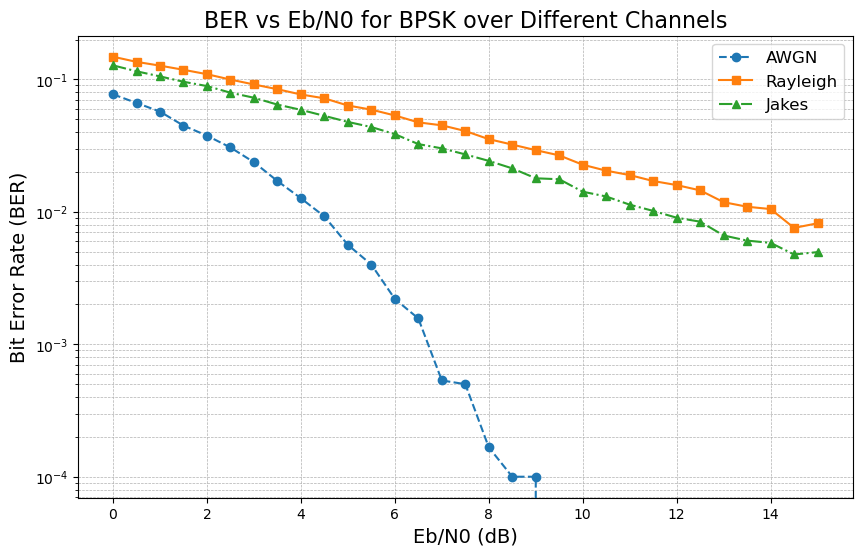

In [12]:
snr_values_np = np.array(snr_values)


plt.figure(figsize=(10, 6))

# Plot the BER for the AWGN channel
plt.plot(snr_values_np, ber_awgn_list, marker='o', linestyle='--', label='AWGN')

# Plot the BER for the Rayleigh fading channel
plt.plot(snr_values_np, ber_ray_list, marker='s', linestyle='-', label='Rayleigh')

# Plot the BER for the Jakes fading channel
plt.plot(snr_values_np, ber_jakes_list, marker='^', linestyle='-.', label='Jakes')

# Plot the BER for the packet-based channel
#plt.plot(snr_values_np, ber_packet_list, marker='d', linestyle=':', label='Packet-Based')

# Set the y-axis to a logarithmic scale
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)', fontsize=14)
plt.ylabel('Bit Error Rate (BER)', fontsize=14)
plt.title('BER vs Eb/N0 for BPSK over Different Channels', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()